<a href="https://colab.research.google.com/github/alima002/rdm1_vqe_prop/blob/main/HF_vqe_2%2C2_gf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install pennylane
!pip install pyscf

#imports

In [2]:
import pennylane as qml
from pyscf import gto, scf, tools
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

#User informations

In [3]:
#modifications that must be made by the user
geom = """
H 0.0  0.0  0.0
F 0.95572  0.0  0.0
"""
charge = 0
mult = 1
spin = 0
verbose=10
basis = "STO-3G"
Ang2Bohr = 1.8897259886

nelec = 10
active_space = True
active_electrons = 2
active_orbitals = 2

#HF has 6 atomic orbitals an 10 electrons: 1 unocuped orbital.

In [4]:
active_indices = [8, 9, 10, 11]

#Functions

In [5]:
def C_2nd_quantization_order(Ca, Cb):
  N = Ca.shape[0]
  M = 2*Ca.shape[1]

  C = np.empty((N,M), dtype=Ca.dtype)

  C[:,0::2] = Ca
  C[:,1::2] = Cb

  return C

In [6]:
#Generating the JW transformation matrix

CREATION_FERMION_OP_TYPE = 0   #The creation operator 𝑎† is defined as (1/2)*(𝑋−𝑖𝑌).
ANNIHILATION_FERMION_OP_TYPE = 1  #The annihilation operator 𝑎 is defined as (1/2)*(𝑋+𝑖𝑌).


def pauli_string_fermion_operator(p, op_type):
  f = (2*op_type-1)*1j    # When op_type = 0 (creation), f = -i, else f = i

  Q_p = 0.5*(qml.PauliX(p) + f * qml.PauliY(p))  #linear combination of the Pauli operators X and Y, with the correct factor to represent the fermion operators

  if p == 0:
    return Q_p

  for i in range(p):
    Q_p = qml.PauliZ(i) @ Q_p  # Adds Z operators to preserve fermionic anticommutation rules.

  return Q_p


def pauli_string_excitation_operator(p, q):
  a_dagger_p = pauli_string_fermion_operator(p, CREATION_FERMION_OP_TYPE)
  a_q = pauli_string_fermion_operator(q, ANNIHILATION_FERMION_OP_TYPE)
  return a_dagger_p @ a_q


In [7]:
#The number of qubits here is calculated using all the orbital spins of the molecule, without considering active spaces

def build_rdm1_active(qubits, ref_hf, ref_active, active_orbitals, active_indices):

    '''
    ref_hf: ON vector obtained with Hartree-Fock
    ref_active: ON vector obtained with VQE
    '''

    active_spin_orbitals = active_orbitals*2
    total_spin_orbitals = qubits

    #--------------- Indexes in the total system and in the active space----------------------------------------------
    #Create a list with the indices of the active spin-orbitals within the complete system.

    active_indices = active_indices

    active_map = {active_indices[i]: i for i in range(active_spin_orbitals)}  #e.g. {4:0, 5:1, 6:2, 7:3}

    print(active_indices)
    print(active_map)
   # Build HF RDM1 (total system)
    Xs = [pauli_string_excitation_operator(q, p) for p in range(total_spin_orbitals) for q in range(total_spin_orbitals)]
    rdm1_hf = np.array([excitation_operator_expval_hf(ref_hf, X_qp) for X_qp in Xs]).reshape((total_spin_orbitals, total_spin_orbitals))

   # Build RDM1 from quantum circuit (active space)
    Xs_active = [pauli_string_excitation_operator(active_map[q], active_map[p])
                 for p in active_indices for q in active_indices]  # Mapping to active space
    rdm1_active = np.array([excitation_operator_expval_active(ref_active, X_qp) for X_qp in Xs_active])
    rdm1_active = rdm1_active.reshape((active_spin_orbitals, active_spin_orbitals))

    # Update HF RDM1 matrix with active space values
    for i, p in enumerate(active_indices):
        for j, q in enumerate(active_indices):
            rdm1_hf[p, q] = rdm1_active[i, j]

    return rdm1_hf

In [8]:
def rdm1_mo2ao(rdm1, C):
  return C @ rdm1 @ C.T

#rdm1 in atomic orbitals
def build_rdm1_ao(qubits, C):
  rdm1 = build_rdm1_active(qubits)
  return rdm1_mo2ao(rdm1, C)

#electron density with pennylane
def compute_electron_density_grid(rdm1, ao_vals):
  return np.einsum("ip,pq,iq->i", ao_vals, rdm1, ao_vals)

In [9]:
#grid
grid = np.linspace(-3.0, 3.0, 60).reshape(-1, 1)
grid = np.hstack([grid, np.zeros((grid.shape[0], 2))])
grid = np.array(grid) * Ang2Bohr

#Pyscf

In [10]:
from pyscf import gto, scf, ci
mol = gto.M(atom=geom, basis=basis, charge=charge, spin=spin, verbose=verbose)
mf = scf.HF(mol).run()
#wf = ci.CISD(mf).run() #
#wf.kernel()

myhf = mol.HF().run()

# For example, to include all electrons in the active space:
wf = myhf.CASSCF(2, 2).run()  # 2 orbitals (4 spins orbitais): 2 electrons (1 orbital) - 1 orbital desocupado


if isinstance(wf, scf.uhf.UHF):  # Path to UHF Class
    Ca, Cb = wf.mo_coeff  # UHF returns two arrays
else:
    Ca = wf.mo_coeff  # RHF or HF returns a single array
    Cb = Ca  # In RHF, the α and β orbitals are the same

S = mol.intor("int1e_ovlp")
I = Ca.T @ S @ Ca

System: uname_result(system='Linux', node='8de3950b53b9', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024', machine='x86_64')  Threads 2
Python 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
numpy 1.26.4  scipy 1.14.1  h5py 3.12.1
Date: Sat Mar 15 14:48:40 2025
PySCF version 2.8.0
PySCF path  /usr/local/lib/python3.11/dist-packages/pyscf

[CONFIG] ARGPARSE = False
[CONFIG] DEBUG = False
[CONFIG] MAX_MEMORY = 4000
[CONFIG] TMPDIR = /tmp
[CONFIG] UNIT = angstrom
[CONFIG] VERBOSE = 3
[CONFIG] conf_file = None
[INPUT] verbose = 10
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 10
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   

In [11]:
C = C_2nd_quantization_order(Ca,Cb) # MO coeff. matrix
print(C)

[[-0.0053278  -0.0053278   0.15086597  0.15086597 -0.53414341 -0.53414341
   0.          0.          0.          0.          1.05386087  1.05386087]
 [ 0.99474743  0.99474743 -0.25065825 -0.25065825 -0.07819725 -0.07819725
   0.          0.          0.          0.          0.08065826  0.08065826]
 [ 0.02225039  0.02225039  0.94657115  0.94657115  0.41064969  0.41064969
   0.          0.          0.          0.         -0.5160127  -0.5160127 ]
 [-0.00266398 -0.00266398 -0.07750889 -0.07750889  0.69780808  0.69780808
   0.          0.          0.          0.          0.81663756  0.81663756]
 [ 0.          0.          0.          0.          0.          0.
   1.          1.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          1.          1.          0.          0.        ]]


In [12]:
rdm1_pyscf = wf.make_rdm1()
print(rdm1_pyscf)


#If UHF or RHF is used, it is necessary sum the two matrices:
#rdm1_pyscf = np.sum(rdm1_pyscf, axis=0)
#print("Shape of rdm1_pyscf:", rdm1_pyscf.shape)

[[ 0.61753979 -0.00259131 -0.15397585 -0.76777657  0.          0.        ]
 [-0.00259131  2.11694151 -0.49453841 -0.07549715  0.          0.        ]
 [-0.15397585 -0.49453841  2.13057251  0.42574567  0.          0.        ]
 [-0.76777657 -0.07549715  0.42574567  0.98670845  0.          0.        ]
 [ 0.          0.          0.          0.          2.          0.        ]
 [ 0.          0.          0.          0.          0.          1.99879026]]


In [13]:
#----------electron density with pyscf----------------

#GTOs calculations
ao_vals_pyscf = gto.eval_gto(mol, "GTOval", grid)

#electron density
density_grid_pyscf = np.einsum("pi,ij,pj->p", ao_vals_pyscf, rdm1_pyscf, ao_vals_pyscf)
print(density_grid_pyscf)

[8.31732679e-08 1.71454008e-07 3.44731892e-07 6.76066594e-07
 1.29324596e-06 2.41310720e-06 4.39255713e-06 7.80163186e-06
 1.35249577e-05 2.29007952e-05 3.79156435e-05 6.14961708e-05
 9.79954631e-05 1.54083153e-04 2.40455417e-04 3.75128639e-04
 5.89623062e-04 9.40093389e-04 1.52621577e-03 2.52055701e-03
 4.20839391e-03 7.03123384e-03 1.16262880e-02 1.89111382e-02
 3.04856082e-02 4.99133882e-02 8.47566599e-02 1.45446259e-01
 2.32319979e-01 3.16862959e-01 3.58428875e-01 3.57168704e-01
 3.59506392e-01 4.10684874e-01 5.28779457e-01 7.08761923e-01
 9.28769597e-01 1.58996334e+00 2.17553779e+01 2.61239929e+02
 1.13172734e+01 1.62617365e+00 1.18413725e+00 8.01151854e-01
 4.74801129e-01 2.52603057e-01 1.24516472e-01 5.93293979e-02
 2.81363262e-02 1.33388385e-02 6.22846058e-03 2.80382991e-03
 1.19399977e-03 4.74508614e-04 1.74370898e-04 5.88291410e-05
 1.80866957e-05 5.01611060e-06 1.23550394e-06 2.63878465e-07]


#Pennylane

In [14]:
geom_data = geom.split()
symbols = tuple(geom_data[4*i] for i in range(len(geom_data)//4))
coordinates = tuple(geom_data[4*i+1:4*i+4] for i in range(len(geom_data)//4))
coordinates = np.array(coordinates, dtype=float).reshape((-1, 3)) * Ang2Bohr

# Set up the molecule object without active space specification
qml_mol = qml.qchem.Molecule(symbols, coordinates, charge=charge, mult=mult, basis_name=basis)

In [15]:
# Calculate the Hamiltonian, the hf_state, and the number of qubits whit Hartree-Fock
H_complet, qubits = qml.qchem.molecular_hamiltonian(qml_mol)

ref_hf = qml.qchem.hf_state(nelec, qubits)

In [16]:
# Calculate the Hamiltonian, the hf_state, and the number of qubits, specifying the active space
H_active, qubits_active = qml.qchem.molecular_hamiltonian(
    qml_mol, active_electrons=active_electrons, active_orbitals=active_orbitals)
if active_space:
    ref_active = qml.qchem.hf_state(active_electrons, qubits_active)
else:
    ref_active = qml.qchem.hf_state(nelec, qubits_active)

In [17]:
print(ref_hf)
print(ref_active)

[1 1 1 1 1 1 1 1 1 1 0 0]
[1 1 0 0]


In [18]:
dev = qml.device("default.qubit", wires=list(range(qubits)))

In [19]:
#X_pq whit HF state

@qml.qnode(dev)
def excitation_operator_expval_hf(ref_hf, X_pq):
  qml.BasisState(ref_hf, wires=range(qubits))
  return qml.expval(X_pq)

In [20]:
#X_pq with VQE

loaded_params = np.load("params_hf_2,2_gf.npy")
expected_shape = qml.GateFabric.shape(n_layers=5, n_wires=qubits_active)
@qml.qnode(dev)
def excitation_operator_expval_active(ref_active, X_pq_active):
    qml.GateFabric(loaded_params, wires=list(range(qubits_active)), init_state=ref_active, include_pi=True)
    return qml.expval(X_pq_active)

In [21]:
rdm1 = build_rdm1_active(qubits=qubits, ref_hf=ref_hf, ref_active=ref_active, active_orbitals=active_orbitals, active_indices=active_indices) #active_indices=active_indices)
print("RDM1 with VQE:")
print(rdm1)

[8, 9, 10, 11]
{8: 0, 9: 1, 10: 2, 11: 3}


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1129: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


RDM1 with VQE:
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.0

In [22]:
@qml.qnode(dev)
def excitation_operator_expval_active(ref_active, H_active):
    qml.GateFabric(loaded_params, wires=list(range(qubits_active)), init_state=ref_active, include_pi=True)
    return qml.expval(H_active)

In [23]:
H_matrix = qml.matrix(H_active, wire_order=list(range(qubits_active)))

eigvals = np.linalg.eigvalsh(H_matrix)
E_ground = np.min(eigvals)
print(f"Ground state energy: {E_ground}")

Ground state energy: -98.57361817589556


In [24]:
rdm1_ao = rdm1_mo2ao(rdm1, C) #convert to AO basis
print('rdm1 in atomic orbitals')
print(rdm1_ao)

rdm1 in atomic orbitals
[[ 0.61754609 -0.00259083 -0.15397894 -0.76777168  0.          0.        ]
 [-0.00259083  2.11694154 -0.49453865 -0.07549678  0.          0.        ]
 [-0.15397894 -0.49453865  2.13057402  0.42574327  0.          0.        ]
 [-0.76777168 -0.07549678  0.42574327  0.98671223  0.          0.        ]
 [ 0.          0.          0.          0.          2.          0.        ]
 [ 0.          0.          0.          0.          0.          1.99878459]]


In [25]:
density_grid = compute_electron_density_grid(rdm1_ao, ao_vals_pyscf)
print(density_grid)

[8.31741167e-08 1.71455758e-07 3.44735410e-07 6.76073493e-07
 1.29325916e-06 2.41313183e-06 4.39260196e-06 7.80171148e-06
 1.35250957e-05 2.29010289e-05 3.79160304e-05 6.14967982e-05
 9.79964624e-05 1.54084723e-04 2.40457863e-04 3.75132445e-04
 5.89629016e-04 9.40102811e-04 1.52623090e-03 2.52058158e-03
 4.20843402e-03 7.03129888e-03 1.16263914e-02 1.89112985e-02
 3.04858520e-02 4.99137634e-02 8.47572614e-02 1.45447238e-01
 2.32321439e-01 3.16864704e-01 3.58430359e-01 3.57169486e-01
 3.59506551e-01 4.10684894e-01 5.28779917e-01 7.08763330e-01
 9.28772296e-01 1.58996659e+00 2.17553786e+01 2.61239933e+02
 1.13172755e+01 1.62617536e+00 1.18413833e+00 8.01152533e-01
 4.74801559e-01 2.52603297e-01 1.24516590e-01 5.93294533e-02
 2.81363529e-02 1.33388521e-02 6.22846778e-03 2.80383369e-03
 1.19400168e-03 4.74509524e-04 1.74371305e-04 5.88293119e-05
 1.80867637e-05 5.01613644e-06 1.23551343e-06 2.63881871e-07]


#Electron density

In [26]:
print('pyscf')
print(rdm1_pyscf)

print('pennylane')
print(rdm1_ao)

pyscf
[[ 0.61753979 -0.00259131 -0.15397585 -0.76777657  0.          0.        ]
 [-0.00259131  2.11694151 -0.49453841 -0.07549715  0.          0.        ]
 [-0.15397585 -0.49453841  2.13057251  0.42574567  0.          0.        ]
 [-0.76777657 -0.07549715  0.42574567  0.98670845  0.          0.        ]
 [ 0.          0.          0.          0.          2.          0.        ]
 [ 0.          0.          0.          0.          0.          1.99879026]]
pennylane
[[ 0.61754609 -0.00259083 -0.15397894 -0.76777168  0.          0.        ]
 [-0.00259083  2.11694154 -0.49453865 -0.07549678  0.          0.        ]
 [-0.15397894 -0.49453865  2.13057402  0.42574327  0.          0.        ]
 [-0.76777168 -0.07549678  0.42574327  0.98671223  0.          0.        ]
 [ 0.          0.          0.          0.          2.          0.        ]
 [ 0.          0.          0.          0.          0.          1.99878459]]


In [27]:
#Differences between electron density with pyscf and pennylane
difference = density_grid - density_grid_pyscf
print(difference)

[8.48839353e-13 1.74980383e-12 3.51822112e-12 6.89971281e-12
 1.31984321e-11 2.46273132e-11 4.48286814e-11 7.96195446e-11
 1.38025867e-10 2.33697469e-10 3.86880618e-10 6.27355741e-10
 9.99277473e-10 1.56991476e-09 2.44617125e-09 3.80575957e-09
 5.95409385e-09 9.42250750e-09 1.51243972e-08 2.45724401e-08
 4.01126813e-08 6.50433566e-08 1.03471020e-07 1.60318506e-07
 2.43874150e-07 3.75202318e-07 6.01505797e-07 9.79378291e-07
 1.45986478e-06 1.74422533e-06 1.48446146e-06 7.82558476e-07
 1.58949172e-07 2.02676000e-08 4.60098380e-07 1.40697401e-06
 2.69920361e-06 3.25199101e-06 6.46160025e-07 4.10715211e-06
 2.04622023e-06 1.70894661e-06 1.07835427e-06 6.79592702e-07
 4.29852092e-07 2.39463913e-07 1.17873325e-07 5.53737586e-08
 2.67272123e-08 1.36362024e-08 7.20397401e-09 3.78334701e-09
 1.90964948e-09 9.09671877e-10 4.06639161e-10 1.70929289e-10
 6.80010074e-11 2.58413855e-11 9.48603837e-12 3.40613262e-12]


In [28]:
difference = rdm1_ao - rdm1_pyscf
print(difference)

[[ 6.30241064e-06  4.82361074e-07 -3.08591391e-06  4.88374258e-06
   0.00000000e+00  0.00000000e+00]
 [ 4.82361074e-07  3.69179696e-08 -2.36183396e-07  3.73781947e-07
   0.00000000e+00  0.00000000e+00]
 [-3.08591391e-06 -2.36183396e-07  1.51098765e-06 -2.39127693e-06
   0.00000000e+00  0.00000000e+00]
 [ 4.88374258e-06  3.73781947e-07 -2.39127693e-06  3.78441567e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -5.67466379e-06]]


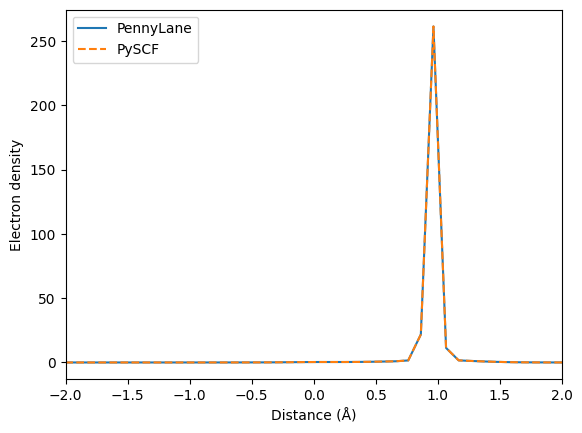

<ipython-input-29-345c4e28ed56>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


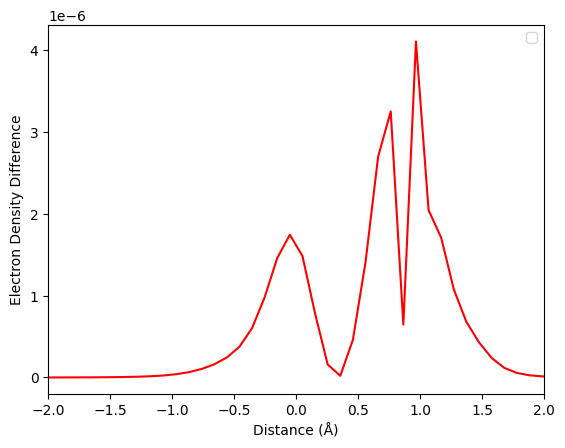

In [29]:
import matplotlib.pyplot as plt

plt.plot(grid[:, 0] / Ang2Bohr, density_grid, label="PennyLane")
plt.plot(grid[:, 0] / Ang2Bohr, density_grid_pyscf, label="PySCF", linestyle="dashed")
plt.xlim(-2, 2)

plt.xlabel("Distance (Å)")
plt.ylabel("Electron density")
plt.legend()
plt.show()

plt.plot(grid[:, 0] / Ang2Bohr, density_grid - density_grid_pyscf, color='red')
plt.xlim(-2, 2)

plt.xlabel("Distance (Å)")
plt.ylabel("Electron Density Difference")
plt.legend()
plt.show()

##Maximum and Minimum values
Bond-critical points (BCP) Is the minimun value

In [30]:
#----------------- PySCF ---------------------------------------------------------

maxima_pyscf = argrelextrema(density_grid_pyscf, np.greater)[0]
minima_pyscf = argrelextrema(density_grid_pyscf, np.less)[0]

#----------------- PennyLane -----------------------------------------------------

maxima_pennylane = argrelextrema(density_grid, np.greater)[0]
minima_pennylane = argrelextrema(density_grid, np.less)[0]

#----------------- Graphs --------------------------------------
x_pyscf = np.linspace(-2, 2, len(density_grid_pyscf))
x_pennylane = np.linspace(-2, 2, len(density_grid))


def print_critical_points_pyscf(label, x_values, density_values):
    for idx in x_values:
        print(f"{label} at x = {x_pyscf[idx]:.3f} Å with density {density_values[idx]:.3f}")


def print_critical_points_pennylane(label, x_values, density_values):
    for idx in x_values:
        print(f"{label} at x = {x_pennylane[idx]:.3f} Å with density {density_values[idx]:.3f}")

print("PySCF Critical Points:")
print_critical_points_pyscf("Local maximum", maxima_pyscf, density_grid_pyscf)
print_critical_points_pyscf("Local minimum", minima_pyscf, density_grid_pyscf)

print("\nPennyLane Critical Points:")
print_critical_points_pennylane("Local maximum", maxima_pennylane, density_grid)
print_critical_points_pennylane("Local minimum", minima_pennylane, density_grid)


PySCF Critical Points:
Local maximum at x = 0.034 Å with density 0.358
Local maximum at x = 0.644 Å with density 261.240
Local minimum at x = 0.102 Å with density 0.357

PennyLane Critical Points:
Local maximum at x = 0.034 Å with density 0.358
Local maximum at x = 0.644 Å with density 261.240
Local minimum at x = 0.102 Å with density 0.357


##Laplacian

Laplacian of a 1D (density) function using the finite difference formula:


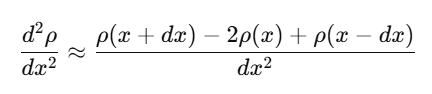


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Function to calculate the Laplacian (second derivative)

def laplacian_1d(rho_data, dx):
    laplacian_data = np.zeros_like(rho_data)

    # Calculate the second derivative in 1D using finite differences
    for i in range(1, len(rho_data) - 1):  #Avoid the edges
        laplacian_data[i] = (rho_data[i+1] - 2 * rho_data[i] + rho_data[i-1]) / dx**2

    return laplacian_data

#----------------- PySCF ---------------------------------------------------------
# Ensures that x has the same size as the density
x_pyscf = np.linspace(-2, 2, len(density_grid_pyscf))
# Calculate the electron density laplacian for PySCF
dx = x_pyscf[1] - x_pyscf[0]  # Considering the spacing between the points of x
laplacian_pyscf = laplacian_1d(density_grid_pyscf, dx)

# Find local maxima and minima
maxima_pyscf = argrelextrema(density_grid_pyscf, np.greater)[0]
minima_pyscf = argrelextrema(density_grid_pyscf, np.less)[0]

#----------------- PennyLane -----------------------------------------------------


x_pennylane = np.linspace(-2, 2, len(density_grid))

dx_pennylane = x_pennylane[1] - x_pennylane[0]
laplacian_pennylane = laplacian_1d(density_grid, dx_pennylane)
maxima_pennylane = argrelextrema(density_grid, np.greater)[0]
minima_pennylane = argrelextrema(density_grid, np.less)[0]

#----------------- Printing the Laplacian at Critical Points -------------------

print("\nLaplacian at Critical Points for PySCF Electron Density:")

print("\nPySCF Local Maxima Laplacian:")
for i in maxima_pyscf:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pyscf[i]:.5f}")

print("\nPySCF Local Minima Laplacian:")
for i in minima_pyscf:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pyscf[i]:5f}")


print("\nLaplacian at Critical Points for PennyLane Electron Density:")

print("\nPennylane Local Maxima Laplacian:")
for i in maxima_pennylane:
    print(f"x = {x_pennylane[i]:.3f} Å: Laplacian = {laplacian_pennylane[i]:.5f}")

print("\nPennylane Local Minima Laplacian:")
for i in minima_pennylane:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pennylane[i]:5f}")



#----------------- Differences between Laplacians and Δρ at Critical Points ------------------

print("\nDifferences between PySCF and PennyLane Laplacian at Critical Points:")

# Differences in local maxima
print("\nDifferences at Local Maxima:")
for i, max_pyscf in enumerate(maxima_pyscf):
    if i < len(maxima_pennylane):
        x_diff = abs(x_pyscf[max_pyscf] - x_pennylane[maxima_pennylane[i]])
        laplacian_diff = abs(laplacian_pyscf[max_pyscf] - laplacian_pennylane[maxima_pennylane[i]])
        rho_diff = abs(density_grid_pyscf[max_pyscf] - density_grid[maxima_pennylane[i]])
        print(f"Max Diff at x = {x_pyscf[max_pyscf]:.5f} Å: Δx = {x_diff:.5f} Å, ΔLaplacian = {laplacian_diff:.5f}, Δρ = {rho_diff:.5f}")

# Differences in local minima
print("\nDifferences at Local Minima:")
for i, min_pyscf in enumerate(minima_pyscf):
    if i < len(minima_pennylane):
        x_diff = abs(x_pyscf[min_pyscf] - x_pennylane[minima_pennylane[i]])
        laplacian_diff = abs(laplacian_pyscf[min_pyscf] - laplacian_pennylane[minima_pennylane[i]])
        rho_diff = abs(density_grid_pyscf[min_pyscf] - density_grid[minima_pennylane[i]])
        print(f"Min Diff at x = {x_pyscf[min_pyscf]:.5f} Å: Δx = {x_diff:.5f} Å, ΔLaplacian = {laplacian_diff:.5f}, Δρ = {rho_diff:.5f}")


Laplacian at Critical Points for PySCF Electron Density:

PySCF Local Maxima Laplacian:
x = 0.034 Å: Laplacian = -9.31735
x = 0.644 Å: Laplacian = -106476.65537

PySCF Local Minima Laplacian:
x = 0.102 Å: Laplacian = 0.782759

Laplacian at Critical Points for PennyLane Electron Density:

Pennylane Local Maxima Laplacian:
x = 0.034 Å: Laplacian = -9.31745
x = 0.644 Å: Laplacian = -106476.65658

Pennylane Local Minima Laplacian:
x = 0.102 Å: Laplacian = 0.782776

Differences between PySCF and PennyLane Laplacian at Critical Points:

Differences at Local Maxima:
Max Diff at x = 0.03390 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00010, Δρ = 0.00000
Max Diff at x = 0.64407 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00120, Δρ = 0.00000

Differences at Local Minima:
Min Diff at x = 0.10169 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00002, Δρ = 0.00000


#Dipole moment

In [32]:
from pyscf.scf.hf import dip_moment

print('Pyscf')
dipole_moment_pyscf = dip_moment(mol, rdm1_pyscf)

print('Pennylane')
dipole_moment_pennylane = dip_moment(mol, rdm1_ao)

print('diferrence: pennylane - pyscf')
difference_dipole = dipole_moment_pennylane - dipole_moment_pyscf
print(difference_dipole)

Pyscf
Dipole moment(X, Y, Z, Debye): -1.24434,  0.00000,  0.00000
Pennylane
Dipole moment(X, Y, Z, Debye): -1.24432,  0.00000,  0.00000
diferrence: pennylane - pyscf
[1.88302999e-05 0.00000000e+00 0.00000000e+00]


In [ ]:
dipole_total_pyscf = np.linalg.norm(dipole_moment_pyscf)
dipole_total_pennylane = np.linalg.norm(dipole_moment_pennylane)
difference_dipole_total = np.linalg.norm(difference_dipole)

print(f'Momento de dipolo total (PySCF): {dipole_total_pyscf}')
print(f'Momento de dipolo total (PennyLane): {dipole_total_pennylane}')
print(f'Diferença total: {difference_dipole_total}')

#Mulliken pop

In [33]:
from pyscf.scf.hf import mulliken_pop

print('Pyscf')
mulliken_pop_pyscf = mulliken_pop(mol, rdm1_pyscf)

print('Pennylane')
mulliken_pop_pennylane = mulliken_pop(mol, rdm1_ao)

Pyscf
 ** Mulliken pop  **
pop of  0 H 1s            0.80996
pop of  1 F 1s            1.99913
pop of  1 F 2s            1.94770
pop of  1 F 2px           1.24442
pop of  1 F 2py           2.00000
pop of  1 F 2pz           1.99879
 ** Mulliken atomic charges  **
charge of    0H =      0.19004
charge of    1F =     -0.19004
Pennylane
 ** Mulliken pop  **
pop of  0 H 1s            0.80996
pop of  1 F 1s            1.99913
pop of  1 F 2s            1.94770
pop of  1 F 2px           1.24443
pop of  1 F 2py           2.00000
pop of  1 F 2pz           1.99878
 ** Mulliken atomic charges  **
charge of    0H =      0.19004
charge of    1F =     -0.19004


In [34]:
# The atomic charges are in the second part of the output tuple
charges_pyscf = mulliken_pop_pyscf[1]
charges_pennylane = mulliken_pop_pennylane[1]

# Calculate the difference between atomic charges
charge_differences = np.array(charges_pyscf) - np.array(charges_pennylane)

print("\nDifference between atomic charges:")
for i, diff in enumerate(charge_differences):
    print(f"Ato {i}: charge difference = {diff:.6f}")


Difference between atomic charges:
Ato 0: charge difference = 0.000003
Ato 1: charge difference = -0.000003


#Electrostatic potential

Guassian: https://mhko.science/p/blog/030-tutorial-how-to-visualize-molecular-electrostatic-potential-with-molekel/

In [39]:
cube_pyscf = tools.cubegen.mep(mol, "mep_pyscf.cube", rdm1_pyscf, resolution=0.1)
cube_pennylane = tools.cubegen.mep(mol, "mep_pennylane.cube", rdm1_ao, resolution=0.1)

In [40]:
bohr_to_angstrom = 0.529177

def read_cube(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    # Skip the first 6 headers of the Cube file
    natoms = int(lines[2].split()[0])
    origin = np.array([float(x) for x in lines[2].split()[1:]])

    # Read grid dimensions
    nx, ny, nz = [int(lines[i].split()[0]) for i in range(3, 6)]
    grid_vectors = np.array([[float(x) for x in lines[i].split()[1:]] for i in range(3, 6)])

    # Calculate the coordinate grid
    x_vals = np.linspace(origin[0], origin[0] + grid_vectors[0, 0] * (nx - 1), nx)
    y_vals = np.linspace(origin[1], origin[1] + grid_vectors[1, 1] * (ny - 1), ny)
    z_vals = np.linspace(origin[2], origin[2] + grid_vectors[2, 2] * (nz - 1), nz)

    # Convert from Bohr to Ångströms
    x_vals *= bohr_to_angstrom
    y_vals *= bohr_to_angstrom
    z_vals *= bohr_to_angstrom

    # Read electrostatic potential data
    data_start = 6 + natoms  # Skip the atom lines
    values = np.array([float(v) for line in lines[data_start:] for v in line.split()])

    # Resize to 3D grid
    data = values.reshape((nx, ny, nz))

    return x_vals, y_vals, z_vals, data


<ipython-input-48-950bfbd26a93>:24: UserWarning: The following kwargs were not used by contour: 'interpolation'
  plt.contourf(X, Z, mep_2d_1.T, levels=100, cmap="RdBu_r",  interpolation="bilinear")
<ipython-input-48-950bfbd26a93>:35: UserWarning: The following kwargs were not used by contour: 'interpolation'
  plt.contourf(X, Z, mep_2d_1.T, levels=100, cmap="RdBu_r",  interpolation="bilinear")


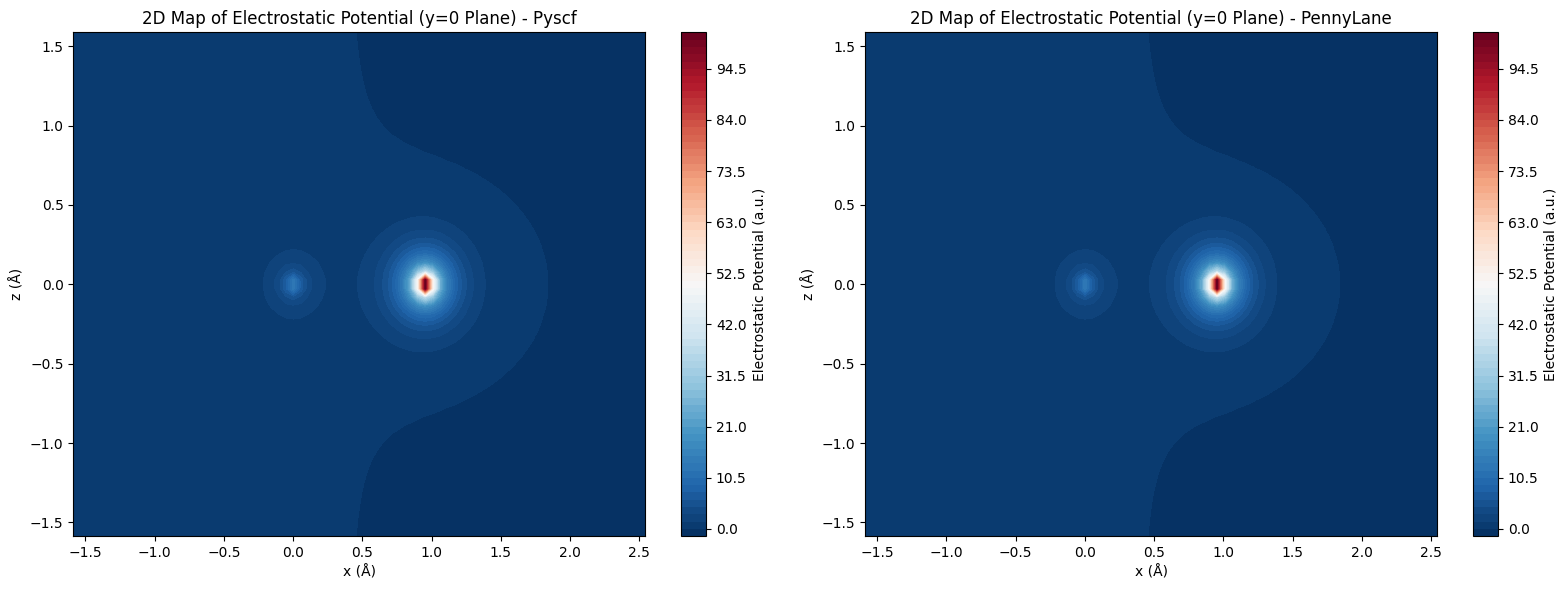

In [48]:
# Read data from the Cube file (Pyscf)


x_vals_1, y_vals_1, z_vals_1, data_1 = read_cube("mep_pyscf.cube")

# Take a cut in the middle of the grid (y plane = 0) for Pyscf
mid_y_1 = len(y_vals_1) // 2  # Central index
mep_2d_1 = data_1[:, mid_y_1, :]  # Grid slicing

# Read data from the Cube file (PennyLane)
x_vals_2, y_vals_2, z_vals_2, data_2 = read_cube("mep_pennylane.cube")

# Take a cut in the middle of the grid (y plane = 0) for PennyLane
mid_y_2 = len(y_vals_2) // 2  # Central index
mep_2d_2 = data_2[:, mid_y_2, :]  # Grid slicing


# Plotting the two heatmaps side by side
plt.figure(figsize=(16, 6))

# Subplot for Pyscf
plt.subplot(1, 2, 1)
X, Z = np.meshgrid(x_vals_1, z_vals_1)
plt.contourf(X, Z, mep_2d_1.T, levels=100, cmap="RdBu_r",  interpolation="bilinear")

plt.colorbar(label="Electrostatic Potential (a.u.)")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("2D Map of Electrostatic Potential (y=0 Plane) - Pyscf")

# Subplot for PennyLane
plt.subplot(1, 2, 2)

X, Z = np.meshgrid(x_vals_2, z_vals_2)
plt.contourf(X, Z, mep_2d_1.T, levels=100, cmap="RdBu_r",  interpolation="bilinear")



#plt.imshow(mep_2d_1.T, extent=[x_vals_1.min(), x_vals_1.max(), z_vals_1.min(), z_vals_1.max()],
          # origin="lower", cmap="RdBu_r", aspect="auto", interpolation="bilinear")


plt.colorbar(label="Electrostatic Potential (a.u.)")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("2D Map of Electrostatic Potential (y=0 Plane) - PennyLane")

plt.tight_layout()
plt.show()


In [49]:
# Calculate min and max values for each dataset
min_1, max_1 = mep_2d_1.min(), mep_2d_1.max()
min_2, max_2 = mep_2d_2.min(), mep_2d_2.max()

# Print the minimum and maximum values for each dataset
print(f"Pyscf - Min: {min_1}, Max: {max_1}")
print(f"PennyLane - Min: {min_2}, Max: {max_2}")


Pyscf - Min: -0.0483784, Max: 101.242
PennyLane - Min: -0.0483774, Max: 101.242


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular a diferença entre os potenciais de Pyscf e PennyLane
mep_diff = mep_2d_1 - mep_2d_2  # Pyscf - PennyLane

print(mep_diff)


[[ 3.e-07  3.e-07  3.e-07 ...  3.e-07  3.e-07  3.e-07]
 [ 2.e-07  3.e-07  3.e-07 ...  3.e-07  3.e-07  2.e-07]
 [ 3.e-07  3.e-07  3.e-07 ...  3.e-07  3.e-07  3.e-07]
 ...
 [-2.e-07 -3.e-07 -3.e-07 ... -3.e-07 -3.e-07 -2.e-07]
 [-3.e-07 -2.e-07 -2.e-07 ... -2.e-07 -2.e-07 -3.e-07]
 [-2.e-07 -3.e-07 -3.e-07 ... -3.e-07 -3.e-07 -2.e-07]]


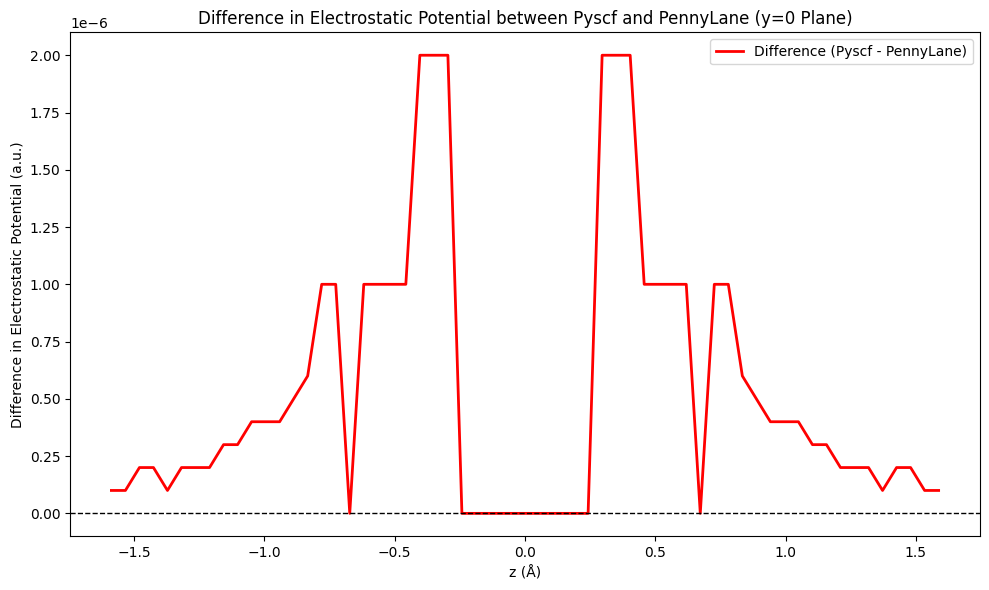

In [62]:
# Select a specific z slice (e.g., z = 0, which has already been selected)
z_index_1 = len(z_vals_1) // 2  # Middle slice for Pyscf
z_index_2 = len(z_vals_2) // 2  # Middle slice for PennyLane

# Get the difference between the two potentials for the y=0 slice
mep_diff = mep_2d_1[z_index_1, :] - mep_2d_2[z_index_2, :]

# Plot the difference in a line graph
plt.figure(figsize=(10, 6))
plt.plot(z_vals_1, mep_diff, label="Difference (Pyscf - PennyLane)", color="r", linewidth=2)

plt.xlabel("z (Å)")
plt.ylabel("Difference in Electrostatic Potential (a.u.)")
plt.title("Difference in Electrostatic Potential between Pyscf and PennyLane (y=0 Plane)")
plt.axhline(0, color='black', linewidth=1, linestyle="--")  # Reference line at y=0
plt.legend()

plt.tight_layout()
plt.show()


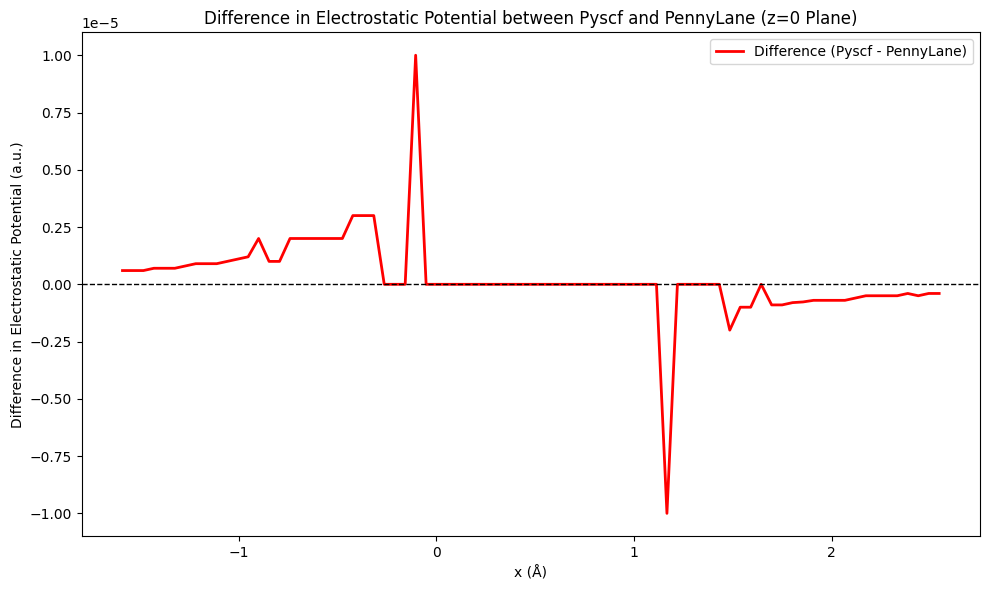

In [66]:
# Select a specific x slice (e.g., x = 0, which has already been selected)
y_index_1 = len(y_vals_1) // 2  # Middle slice for Pyscf
y_index_2 = len(y_vals_2) // 2  # Middle slice for PennyLane

# Get the difference between the two potentials for the y=0 slice
mep_diff = mep_2d_1[:, y_index_1] - mep_2d_2[:, y_index_2]

# Plot the difference in a line graph
plt.figure(figsize=(10, 6))
plt.plot(x_vals_1, mep_diff, label="Difference (Pyscf - PennyLane)", color="r", linewidth=2)

plt.xlabel("x (Å)")
plt.ylabel("Difference in Electrostatic Potential (a.u.)")
plt.title("Difference in Electrostatic Potential between Pyscf and PennyLane (z=0 Plane)")
plt.axhline(0, color='black', linewidth=1, linestyle="--")  # Reference line at y=0
plt.legend()

plt.tight_layout()
plt.show()
